<a href="https://colab.research.google.com/github/LaurentSeguin/Learning_ML/blob/main/Python_Classificaiton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. Network Classification with Pytorch

## 1. Make Classification Data and get it ready

In [1]:
import sklearn
from sklearn.datasets import make_circles


In [2]:
# Make 1000 samples
n_samples =1000
X,y = make_circles(n_samples,
                   noise=0.03,
                   random_state=42)

In [3]:
len(X),len(y)

(1000, 1000)

In [4]:
print(f"First 5 samples of X: {X[:5]}")
print(f"First 5 samples of y: {y[:5]}")

First 5 samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: [1 1 1 1 0]


In [5]:
X[:5,1]

array([ 0.23148074,  0.15325888,  0.17328203,  0.69288277, -0.89672343])

In [6]:
# Make a dataaframe of circle data
import pandas as pd
circles = pd.DataFrame({"X1":X[:,0],
                        "X2":X[:,1],
                        "Label":y})

In [7]:
circles.head()

,X1,X2,Label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


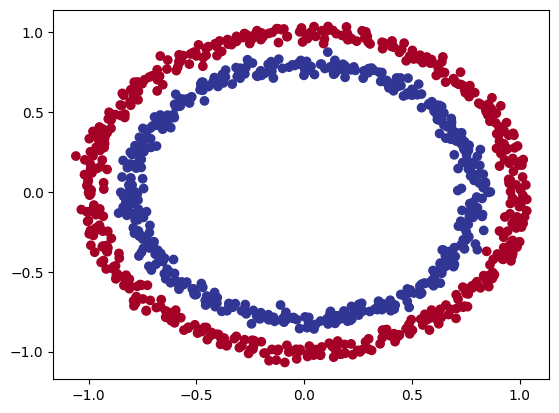

In [8]:
# Make some visualization
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

### 1.1 Check input and output shapes

In [9]:
X.shape,y.shape

((1000, 2), (1000,))

In [10]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Convert data into tensors and split data into train and test split

In [11]:
import torch


In [12]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [13]:
X[:5],y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [14]:
X.dtype,y.dtype

(torch.float32, torch.float32)

In [15]:
# Split the data in training and testing sets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [16]:
len(X_train),len(y_train),len(X_test),len(y_test)

(800, 800, 200, 200)

In [17]:
# Setup code agnostic
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


## 2. Building  a model

we will build a model to classify the blue and red dots. We will follow the following steps:

  1. Setup device agonistic code so that our code run on GPU if available
  2. Construct a model by subclassing the `nn.Module` class of pytorch
  3. Define a loss function and optimizer
  4. Create a training and test loop

#### 2.1 Setup device agnostic code

In [18]:
# import Pytorch and nn
import torch
from torch import nn

# Make device agnositic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


#### 2.2 Construct a model by subclass `nn.Module`
We will follow the step below to create a model:
  1. Subclasses `nn.Module`
  2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
  3. Defines a `forward()` method that outlines the forward pass of the model.
  4. Instatiate an instance of our model class and it to the target `device`

In [19]:
X_train.shape

torch.Size([800, 2])

In [20]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.linear layers capable of handling the shapes of our model
    self.layer_1 = nn.Linear(in_features=2,out_features=5)
    self.layer_2 = nn.Linear(in_features=5,out_features=1)
  # 3. Define the forward pass
  def forward(self,x):
    return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output
# 4. Instantiate an instance of the model and send it to device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [21]:
next(model_0.parameters())

Parameter containing:
tensor([[-0.5393, -0.1588],
        [-0.5380, -0.3019],
        [-0.1221,  0.5274],
        [ 0.1673, -0.1019],
        [ 0.3264, -0.2678]], requires_grad=True)

In [22]:
# Creating the same model using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [23]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.5791, -0.3286],
                      [-0.2848,  0.0955],
                      [ 0.0916, -0.4731],
                      [ 0.6774, -0.1408],
                      [ 0.0852, -0.2636]])),
             ('0.bias', tensor([ 0.2023, -0.3081, -0.3626, -0.5295, -0.6620])),
             ('1.weight',
              tensor([[ 0.2529,  0.3517,  0.4190, -0.0180, -0.1257]])),
             ('1.bias', tensor([-0.1373]))])

In [24]:
# Make Prediction
with torch.inference_mode():
  untrained_preds =torch.round(model_0(X_test.to(device)))
  print(f"Length of Prediction: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
  print(f"Length of test samples: {len(X_test)},Shape: {X_test.shape}")
  print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
  print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of Prediction: 200, Shape: torch.Size([200, 1])
Length of test samples: 200,Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.]])

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup Loss function and optimizer


In [25]:
from torch import optim
# Setup Binary Cross entropy loss
# When using BCELoss(), the previous output must go through a sigmoid function before.
# The BCEWithLogitsLoss() as the sigmoid activation function build-in
loss_fn = nn.BCEWithLogitsLoss()
# Setup SGD optimizer
optimizer = optim.SGD(params=model_0.parameters(),lr=0.01)

In [26]:
# Calculate accuracy - what percentage does our model get right?
def accuracy_fn(y_true,y_pred):
  correct = torch.eq(y_true,y_pred).sum().item() # torch.eq will output the number of times y_true == y_pred and sum it with .sum() the amount. item() return just the python number
  acc= (correct/len(y_pred))*100
  return acc


### 3.0 Training The model
 Build a Training Loop
 Steps:
  1. Forward Pass
  2. Calculate the loss
  3. Optimizer zero grad
  4. Loss backward
  5. Optimizer step

#### 3.1 Going from raw logits -> prediction probabilities -> prediction  labels
Before creating the training loop, we need to process the raw logits of the model.The raw logits output from the models needs to be converted to predictions probabilities by passing them to an activation function. Sigmoid for binary and Softmax for Multiclass.

In [27]:
#  View the first 5 outputs of the forward pass on data
model_0.eval()
with torch.inference_mode():
  y_logits= model_0(X_test.to(device))[:10]
y_logits

tensor([[-0.4216],
        [-0.4563],
        [-0.2303],
        [-0.4762],
        [-0.0710],
        [-0.0935],
        [-0.3174],
        [-0.2320],
        [-0.2373],
        [-0.4569]])

In [28]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [29]:
# Use the sigmoid function on the model logits.
y_pred_probs= torch.sigmoid(y_logits)

In [30]:
y_pred_probs

tensor([[0.3961],
        [0.3879],
        [0.4427],
        [0.3831],
        [0.4822],
        [0.4767],
        [0.4213],
        [0.4423],
        [0.4409],
        [0.3877]])

For our prediction probabiility values.. we need to perform a range-style rounding on them

  * y_pred_probs >= 0.5, y = 1 (class 1)
  * y_pred_probs < 0.5, y = 0 (class 0)

In [31]:
# Find the predicted labels from the pred_prod
y_pred_labels = torch.round(y_pred_probs).squeeze()
y_pred_labels

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

#### 3.2 Building a training and testing

In [32]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set the number of epochs
epochs = 100

# Put data to device
X_train,y_train = X_train.to(device),y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)

# Build training and evalaution loop
for epoch in range(epochs):
  model_0.train()
  #1. Forward Pass
  y_logits=model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # Turn Logits -> pred probs -> pred labels
  # 2. Calculate loss and accuracy
  loss = loss_fn(y_logits,y_train) # we pass logits because we used BCEwithlogitsloss. It expect logits as input and it will apply the sigmoid layer itself
  acc = accuracy_fn(y_true=y_train,y_pred=y_pred)
  # 3.. Optimizer zero grad
  optimizer.zero_grad()
  # 4. Loss Backward
  loss.backward()
  # 5. Optimizer Step
  optimizer.step()

  #### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward Pass
    test_logits = model_0(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))
    # 2. Calculate Loss and Accuracy
    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_true=y_test,y_pred=test_preds)
  # Print out training infor
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, ACC:{acc:.2f}%  | Test Loss: {test_loss:.5f}, Test acc: {test_acc:.2f}% ")


Epoch: 0 | Loss: 0.70442, ACC:50.00%  | Test Loss: 0.70044, Test acc: 50.00% 
Epoch: 10 | Loss: 0.70339, ACC:50.00%  | Test Loss: 0.69942, Test acc: 50.00% 
Epoch: 20 | Loss: 0.70247, ACC:50.00%  | Test Loss: 0.69852, Test acc: 50.00% 
Epoch: 30 | Loss: 0.70165, ACC:48.88%  | Test Loss: 0.69771, Test acc: 49.50% 
Epoch: 40 | Loss: 0.70092, ACC:46.62%  | Test Loss: 0.69700, Test acc: 48.50% 
Epoch: 50 | Loss: 0.70027, ACC:44.12%  | Test Loss: 0.69636, Test acc: 46.00% 
Epoch: 60 | Loss: 0.69968, ACC:42.25%  | Test Loss: 0.69580, Test acc: 44.50% 
Epoch: 70 | Loss: 0.69916, ACC:41.12%  | Test Loss: 0.69530, Test acc: 43.00% 
Epoch: 80 | Loss: 0.69870, ACC:41.38%  | Test Loss: 0.69485, Test acc: 42.00% 
Epoch: 90 | Loss: 0.69828, ACC:42.62%  | Test Loss: 0.69446, Test acc: 44.00% 


## 4. Make predictions and evaluating the model

From the metrics , we can see that the model is not performing well.
Hence we will try to make some prediction and visualize them to see how can we improve the model

In [33]:
import requests
from pathlib import Path

# Download helper functions,
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exist")
else:
  print("Download helper_function.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions,plot_decision_boundary

Download helper_function.py


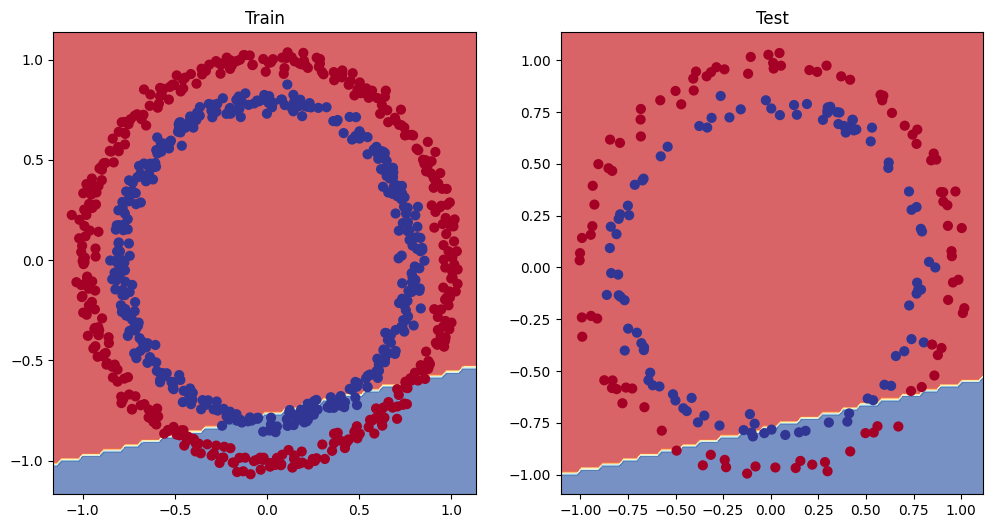

In [34]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test,y_test)

## 5. Improving the results
  * Add more layers = give the model more chances to learn pattern in the data
  * Add mor Hidden units
  * Fit for longer
  * Change activation functions
  * Change of the learning rate
  * Change the loss function


In [35]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,out_features=10)
    self.layer_2 = nn.Linear(in_features=10,out_features=10)
    self.layer_3 = nn.Linear(in_features=10,out_features=1)

  def forward(self,x):
    #z= self.layer_1(x)
    #z= self.layer_2(z)
    #z= self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x)))
model_1 = CircleModelV1()
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [36]:
device

'cpu'

In [37]:
# Create a los Function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),lr=0.1)

In [38]:
# Create a training loop
epochs=1000
torch.manual_seed(42)
torch.cuda.manual_seed(42)
# Put data and model to device
X_train,y_train = X_train.to(device),y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)
model_1.to(device)
model_1.train()
for epoch in range(epochs):
  #Forward pass
  y_logits = model_1(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))
  # Calculate loss
  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_true=y_train,y_pred=y_preds)
  # Optimizer zero grad
  optimizer.zero_grad()
  # Loss backward
  loss.backward()
  # Optimizer step
  optimizer.step()
  # Put model in eval mode
  model_1.eval()
  with torch.inference_mode():
    # Forward pass
    test_logits = model_1(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))
    # Calculate test loss and accuracy
    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_true=y_test,y_pred=test_preds)

  if epoch %  10 == 0:
    print(f"Epoch: {epoch} |cudaLoss: loss | Accuracy: {acc:.2f}% | Test Loss: {test_loss} | Test Accuracy: {test_acc:.2f}% ")


Epoch: 0 |cudaLoss: loss | Accuracy: 50.88% | Test Loss: 0.6926146149635315 | Test Accuracy: 51.00% 
Epoch: 10 |cudaLoss: loss | Accuracy: 50.25% | Test Loss: 0.6927037239074707 | Test Accuracy: 50.00% 
Epoch: 20 |cudaLoss: loss | Accuracy: 50.12% | Test Loss: 0.6928302049636841 | Test Accuracy: 49.50% 
Epoch: 30 |cudaLoss: loss | Accuracy: 50.50% | Test Loss: 0.6929664015769958 | Test Accuracy: 48.00% 
Epoch: 40 |cudaLoss: loss | Accuracy: 50.38% | Test Loss: 0.693103015422821 | Test Accuracy: 49.00% 
Epoch: 50 |cudaLoss: loss | Accuracy: 49.88% | Test Loss: 0.6932356953620911 | Test Accuracy: 50.00% 
Epoch: 60 |cudaLoss: loss | Accuracy: 49.38% | Test Loss: 0.6933621764183044 | Test Accuracy: 51.50% 
Epoch: 70 |cudaLoss: loss | Accuracy: 49.38% | Test Loss: 0.6934814453125 | Test Accuracy: 50.50% 
Epoch: 80 |cudaLoss: loss | Accuracy: 50.12% | Test Loss: 0.6935926675796509 | Test Accuracy: 50.00% 
Epoch: 90 |cudaLoss: loss | Accuracy: 50.50% | Test Loss: 0.6936956644058228 | Test Acc

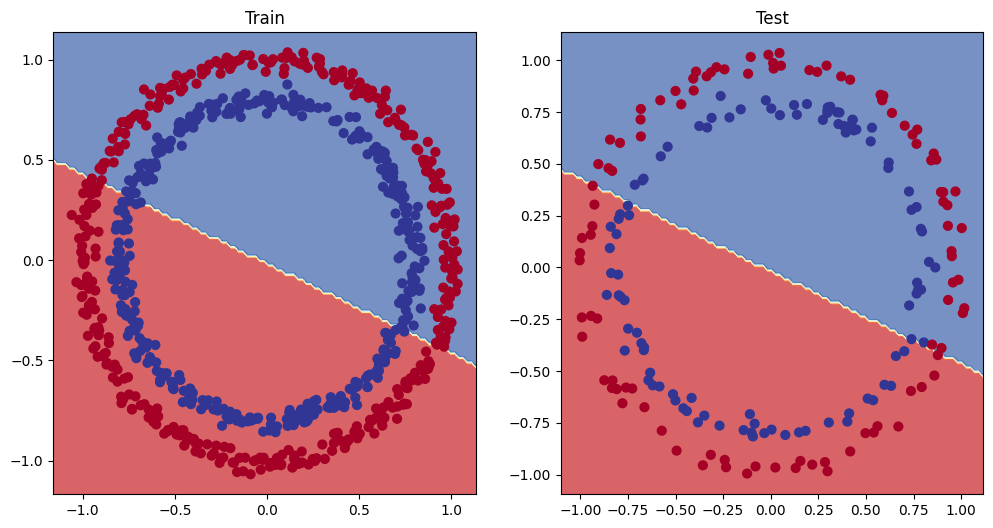

In [39]:
# Plot the decision boundary
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1,X_test,y_test)

In [40]:
# Create data
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01
X = torch.arange(start,end,step).unsqueeze(dim=1)
y = weight*X + bias
# Split Data
train_split = int(0.8*len(X))
X_train_reg,y_train_reg,X_test_reg,y_test_reg= X[:train_split],y[:train_split],X[train_split:],y[train_split:]

In [41]:
len(X_train_reg),len(y_train_reg),len(X_test_reg),len(y_test_reg)

(80, 80, 20, 20)

In [42]:
X_train_reg[:5],y_train_reg[:5]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

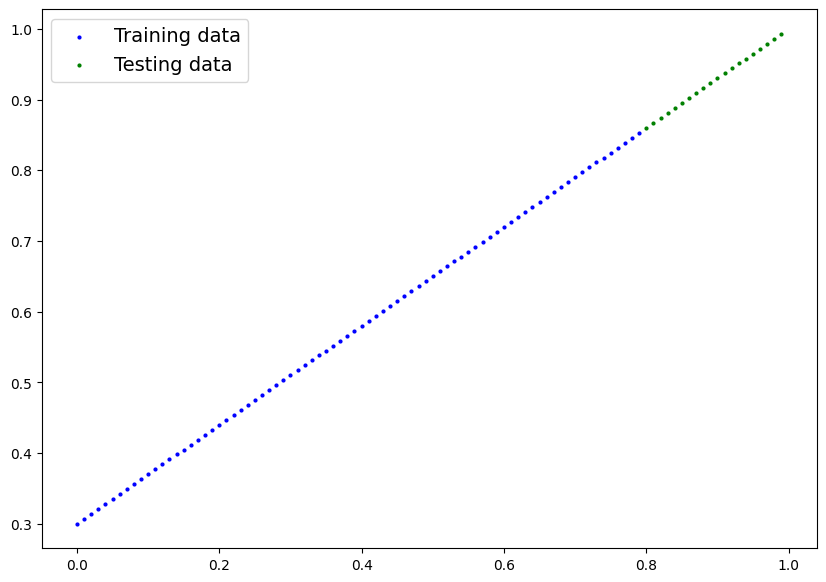

In [43]:
plot_predictions(X_train_reg,y_train_reg,X_test_reg,y_test_reg)

In [44]:
# Re-create model 1 for this data
class model_1_regression(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features= 1, out_features=10)
    self.layer_2 = nn.Linear(in_features=10,out_features=10)
    self.layer_3 = nn.Linear(in_features=10,out_features=1)
  def forward(self,x):
    return self.layer_3(self.layer_2(self.layer_1(x)))

In [45]:
model_1_reg= model_1_regression()

In [46]:
model_1_reg

model_1_regression(
  (layer_1): Linear(in_features=1, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

##### Another way
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

In [47]:
# Create Loss function
loss_fn = nn.L1Loss()
# Create Optimizer
optim = torch.optim.SGD(model_1_reg.parameters(),lr=0.1)

In [48]:
X_train_reg.shape

torch.Size([80, 1])

In [49]:
# Create the Training loop
epochs =1000
# Transfering data and model to device
X_train_reg,y_train_reg = X_train_reg.to(device),y_train_reg.to(device)
X_test_reg,y_test_reg = X_test_reg.to(device),y_test_reg.to(device)
model_1_reg.to(device)
# Set model in training mode
model_1_reg.train()
for epoch in range(epochs):
  # 1. Forward Pass
  y_preds_reg= model_1_reg(X_train_reg)
  #_preds = torch.round(torch.sigmoid(y_logits))
  # Calculate loss and accuracy
  train_loss_reg=  loss_fn(y_preds_reg,y_train_reg)

  # Optimizer zero grad
  optim.zero_grad()
  # Loss backward
  train_loss_reg.backward()
  # Optimizer Step
  optim.step()
  # Put model in eval mode
  model_1_reg.eval()
  with torch.inference_mode():
    test_preds_reg= model_1_reg(X_test_reg)

    # Calculate test loss and accuracy
    test_loss_reg = loss_fn(test_preds_reg,y_test_reg)
  if epoch % 10 ==0:
    print(f"Epoch: {epoch} | Loss: {train_loss_reg}  | Test Loss: {test_loss_reg}")

Epoch: 0 | Loss: 0.7598584890365601  | Test Loss: 0.541427731513977
Epoch: 10 | Loss: 0.14550209045410156  | Test Loss: 0.02363099716603756
Epoch: 20 | Loss: 0.14420080184936523  | Test Loss: 0.055966150015592575
Epoch: 30 | Loss: 0.10136198997497559  | Test Loss: 0.03785458207130432
Epoch: 40 | Loss: 0.07525161653757095  | Test Loss: 0.009844166226685047
Epoch: 50 | Loss: 0.07625240832567215  | Test Loss: 0.021022215485572815
Epoch: 60 | Loss: 0.10319753736257553  | Test Loss: 0.027536705136299133
Epoch: 70 | Loss: 0.08642620593309402  | Test Loss: 0.010074108839035034
Epoch: 80 | Loss: 0.06936904788017273  | Test Loss: 0.013261562213301659
Epoch: 90 | Loss: 0.08678261190652847  | Test Loss: 0.030268916860222816
Epoch: 100 | Loss: 0.09308688342571259  | Test Loss: 0.029011687263846397
Epoch: 110 | Loss: 0.06734553724527359  | Test Loss: 0.009729022160172462
Epoch: 120 | Loss: 0.08537852019071579  | Test Loss: 0.03464330732822418
Epoch: 130 | Loss: 0.07850158214569092  | Test Loss: 0.0

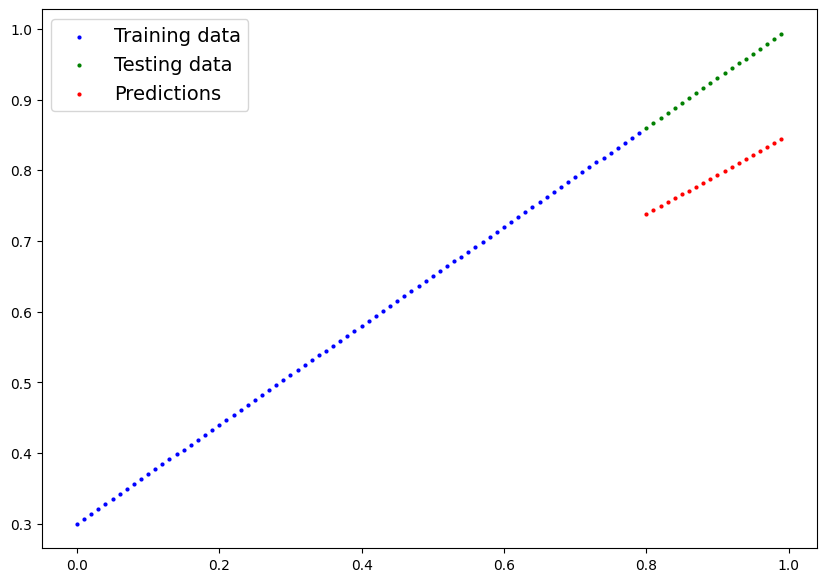

In [50]:
# Make some prediction
model_1_reg.eval()
with torch.inference_mode():
  y_preds_reg = model_1_reg(X_test_reg)
plot_predictions(X_train_reg.cpu(),y_train_reg.cpu(),X_test_reg.cpu(),y_test_reg.cpu(),y_preds_reg.cpu())